# PATH WAYPOINTS AS PARAMETRIZED CURVE

In this notebook I try to reproduce the parmetrization of the track via curve-fitting like its done in Udacity MPC Course. 
在这篇笔记中，我试图通过曲线拟合来重现轨迹的参数化，就像在Udacity MPC课程中所做的那样。

In [4]:
import numpy as np
from scipy.interpolate import interp1d

# 函数 compute_path_from_wp 用于生成平滑的轨迹。
# 输入：start_xp 和 start_yp 分别是路径点的 x 和 y 坐标，step 是插值的步长。
# 作用：通过使用线性插值的方法，在每两个路径点之间生成一些中间点，使路径更加平滑。
# 细节：
# 计算每段路径的长度。
# 使用 interp1d 对每两个路径点进行线性插值，从而在每段路径之间生成更多的中间点。
# 最后返回平滑后的路径点集合。
def compute_path_from_wp(start_xp, start_yp, step=0.1):
    final_xp = []
    final_yp = []
    delta = step  # [m]

    for idx in range(len(start_xp) - 1):
        section_len = np.sum(
            np.sqrt(
                np.power(np.diff(start_xp[idx : idx + 2]), 2)
                + np.power(np.diff(start_yp[idx : idx + 2]), 2)
            )
        )

        interp_range = np.linspace(0, 1, np.floor(section_len / delta).astype(int))

        fx = interp1d(np.linspace(0, 1, 2), start_xp[idx : idx + 2], kind=1)
        fy = interp1d(np.linspace(0, 1, 2), start_yp[idx : idx + 2], kind=1)

        final_xp = np.append(final_xp, fx(interp_range))
        final_yp = np.append(final_yp, fy(interp_range))

    return np.vstack((final_xp, final_yp))

# 函数 get_nn_idx 用于找到车辆当前状态下，最接近的路径点索引。
# 
# 输入：state 是车辆的当前位置和航向角信息，path 是轨迹点集合。
# 作用：找到车辆当前位置与轨迹的最近点，并根据路径点的方向矢量来决定目标点的位置。
# 细节：
# 计算车辆与路径点之间的欧氏距离，通过 np.argmin(dist) 找到最近的路径点索引。
# 然后根据路径点方向矢量，判断是否需要向前一个点继续行驶，最终返回目标路径点索引 target_idx。
def get_nn_idx(state, path):

    dx = state[0] - path[0, :]
    dy = state[1] - path[1, :]
    dist = np.sqrt(dx**2 + dy**2)
    nn_idx = np.argmin(dist)

    try:
        v = [
            path[0, nn_idx + 1] - path[0, nn_idx],
            path[1, nn_idx + 1] - path[1, nn_idx],
        ]
        v /= np.linalg.norm(v)

        d = [path[0, nn_idx] - state[0], path[1, nn_idx] - state[1]]

        if np.dot(d, v) > 0:
            target_idx = nn_idx
        else:
            target_idx = nn_idx + 1

    except IndexError as e:
        target_idx = nn_idx

    return target_idx

In [6]:
# define track
wp = np.array([0, 5, 6, 10, 11, 15, 0, 0, 2, 2, 0, 4]).reshape(2, -1)
track = compute_path_from_wp(wp[0, :], wp[1, :], step=0.5)

# vehicle state
state = [3.5, 0.5, np.radians(30)]

# given vehicle pos find lookahead waypoints
nn_idx = (
    get_nn_idx(state, track) - 1
)  # index ox closest wp, take the previous to have a straighter line
LOOKAHED = 6
lk_wp = track[:, nn_idx : nn_idx + LOOKAHED]

# trasform lookahead waypoints to vehicle ref frame
# 转换前视路径点到车辆参考框架
dx = lk_wp[0, :] - state[0]
dy = lk_wp[1, :] - state[1]

wp_vehicle_frame = np.vstack(
    (
        dx * np.cos(-state[2]) - dy * np.sin(-state[2]),
        dy * np.cos(-state[2]) + dx * np.sin(-state[2]),
    )
)

# fit poly
# 拟合多项式
coeff = np.polyfit(
    wp_vehicle_frame[0, :],
    wp_vehicle_frame[1, :],
    5,
    rcond=None,
    full=False,
    w=None,
    cov=False,
)

# def f(x,coeff):
#    return coeff[0]*x**3+coeff[1]*x**2+coeff[2]*x**1+coeff[3]*x**0
def f(x, coeff):
    return (
        coeff[0] * x**5
        + coeff[1] * x**4
        + coeff[2] * x**3
        + coeff[3] * x**2
        + coeff[4] * x**1
        + coeff[5] * x**0
    )


def f(x, coeff):
    y = 0
    j = len(coeff)
    for k in range(j):
        y += coeff[k] * x ** (j - k - 1)
    return y


# def df(x,coeff):
#     return round(3*coeff[0]*x**2 + 2*coeff[1]*x**1 + coeff[2]*x**0,6)
def df(x, coeff):
    y = 0
    j = len(coeff)
    for k in range(j - 1):
        y += (j - k - 1) * coeff[k] * x ** (j - k - 2)
    return y


/var/folders/hd/8kg_jtmd6svgg_sc384pbcdm0000gn/T/ipykernel_8828/1217459931.py:29: RankWarning: Polyfit may be poorly conditioned
  coeff = np.polyfit(


In [3]:
coeff

array([ 0.10275887,  0.03660033, -0.21750601,  0.03551043, -0.53861442,
       -0.58083993])

In [9]:
wp_vehicle_frame[0, :]

array([-0.39433757,  0.08678766,  0.56791288,  1.04903811,  1.04903811,
        1.67104657])

In [10]:
wp_vehicle_frame[1, :]

array([-0.34967937, -0.62745715, -0.90523492, -1.1830127 , -1.1830127 ,
       -0.7723291 ])

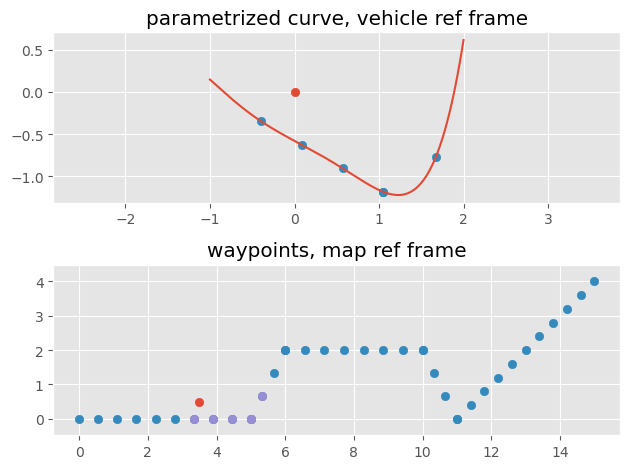

In [4]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")

x = np.arange(-1, 2, 0.001)  # interp range of curve

# VEHICLE REF FRAME
plt.subplot(2, 1, 1)
plt.title("parametrized curve, vehicle ref frame")
plt.scatter(0, 0)
plt.scatter(wp_vehicle_frame[0, :], wp_vehicle_frame[1, :])
plt.plot(x, [f(xs, coeff) for xs in x])
plt.axis("equal")

# MAP REF FRAME
plt.subplot(2, 1, 2)
plt.title("waypoints, map ref frame")
plt.scatter(state[0], state[1])
plt.scatter(track[0, :], track[1, :])
plt.scatter(track[0, nn_idx : nn_idx + LOOKAHED], track[1, nn_idx : nn_idx + LOOKAHED])
plt.axis("equal")

plt.tight_layout()
plt.show()
# plt.savefig("fitted_poly")

## Error Formulation 误差公式

So, the track can be represented by fitting a curve trough its waypoints, using the vehicle position as reference!
因此，可以通过拟合一条曲线穿过路径点来表示轨迹，并使用车辆位置作为参考！

<!-- ![mpc](img/fitted_poly.png) -->

Recall A fitted cubic poly has the form:
回顾一下，拟合的三次多项式形式为：

$
f = K_0 * x^3 + K_1 * x^2 + K_2 * x + K_3
$

The derivative of a fitted cubic poly has the form:
拟合的三次多项式的导数形式为：

$
f' = 3.0 * K_0 * x^2 + 2.0 * K_1 * x + K_2
$

Then we can formulate
然后我们可以进行如下公式化

* **crosstrack error** cte: desired y-position - y-position of vehicle -> this is the value of the fitted polynomial
* **横向误差** cte：期望的y位置 - 车辆的y位置 -> 这是拟合多项式的值

* **heading error** epsi:  desired heading - heading of vehicle -> is the inclination of  tangent to the  fitted polynomial
* **航向误差** epsi：期望航向 - 车辆航向 -> 是拟合多项式的切线的倾斜

Becouse the reference is centered on vehicle the eqation are simplified!
Then using the fitted polynomial representation in vehicle frame the errors can be easily computed as:
因为参考点是以车辆为中心的，方程得到了简化！
因此，使用车辆坐标系中的拟合多项式表示，可以很容易地计算误差：

$
cte = f(px) \\
\psi = -atan(f`(px)) \\
$

### In Practice:
I use a **convex** mpc so non-linearities are not allowed (in Udacity they use a general-purpose nonlinear solver) -> so this solution does not really work well for my case...
我使用了一个凸优化的 MPC，因此不允许非线性项（在 Udacity 的课程中，他们使用的是通用的非线性求解器） -> 因此这个解决方案对于我的情况并不太适用

### Extras

In [7]:
# 五次样条曲线
# def spline_planning(qs, qf, ts, tf, dqs=0.0, dqf=0.0, ddqs=0.0, ddqf=0.0):
# 
#     bc = np.array([ys, dys, ddys, yf, dyf, ddyf]).T
# 
#     C = np.array(
#         [
#             [1, xs, xs**2, xs**3, xs**4, xs**5],  # f(xs)=ys
#             [0, 1, 2 * xs**1, 3 * xs**2, 4 * xs**3, 5**xs ^ 4],  # df(xs)=dys
#             [0, 0, 1, 6 * xs**1, 12 * xs**2, 20**xs ^ 3],  # ddf(xs)=ddys
#             [1, xf, xf**2, xf**3, xf**4, xf**5],  # f(xf)=yf
#             [0, 1, 2 * xf**1, 3 * xf**2, 4 * xf**3, 5**xf ^ 4],  # df(xf)=dyf
#             [0, 0, 1, 6 * xf**1, 12 * xf**2, 20**xf ^ 3],
#         ]
#     )  # ddf(xf)=ddyf
# 
#     # To compute the polynomial coefficients we solve:
#     # Ax = B.
#     # Matrices A and B must have the same number of rows
#     a = np.linalg.lstsq(C, bc)[0]
#     return a

In [8]:
import numpy as np

def spline_planning(xs, xf, ys, yf, dys=0.0, dyf=0.0, ddys=0.0, ddyf=0.0):
    """
    计算五次多项式的系数，满足边界条件。

    参数：
    - xs: 初始位置 x
    - xf: 最终位置 x
    - ys: 初始位置 y
    - yf: 最终位置 y
    - dys: 初始速度 (默认值为 0)
    - dyf: 最终速度 (默认值为 0)
    - ddys: 初始加速度 (默认值为 0)
    - ddyf: 最终加速度 (默认值为 0)

    返回：
    - a: 五次多项式的系数
    """
    # 定义边界条件矩阵 B
    bc = np.array([ys, dys, ddys, yf, dyf, ddyf])

    # 定义系数矩阵 A
    C = np.array(
        [
            [1, xs, xs**2, xs**3, xs**4, xs**5],  # f(xs)=ys
            [0, 1, 2 * xs, 3 * xs**2, 4 * xs**3, 5 * xs**4],  # df(xs)=dys
            [0, 0, 2, 6 * xs, 12 * xs**2, 20 * xs**3],  # ddf(xs)=ddys
            [1, xf, xf**2, xf**3, xf**4, xf**5],  # f(xf)=yf
            [0, 1, 2 * xf, 3 * xf**2, 4 * xf**3, 5 * xf**4],  # df(xf)=dyf
            [0, 0, 2, 6 * xf, 12 * xf**2, 20 * xf**3],  # ddf(xf)=ddyf
        ]
    )

    # 计算多项式系数
    a = np.linalg.solve(C, bc)  # 使用线性方程组求解 A * a = B
    return a

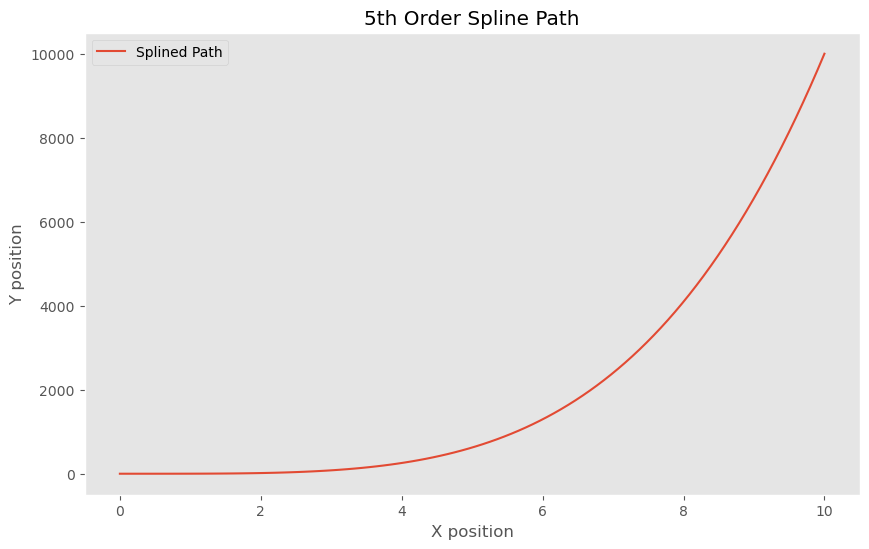

In [11]:
import matplotlib.pyplot as plt

# 初始和最终位置及其条件
xs = 0  # 初始位置
xf = 10  # 最终位置
ys = 0  # 初始位置 y
yf = 5  # 最终位置 y
dys = 1.0  # 初始速度
dyf = 0.5  # 最终速度

# 计算多项式系数
coefficients = spline_planning(xs, xf, ys, yf, dys, dyf)

# 使用计算出的系数生成样条曲线
x_vals = np.linspace(xs, xf, 100)
y_vals = [
    coefficients[0] * x**5 + coefficients[1] * x**4 + coefficients[2] * x**3 + coefficients[3] * x**2 + coefficients[4] * x + coefficients[5]
    for x in x_vals
]

# 绘制样条曲线
plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, label='Splined Path')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('5th Order Spline Path')
plt.legend()
plt.grid()
plt.show()